# Trained Machine Learning Models for Quora question pairs:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os,pickle
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
os.chdir('/content/gdrive/MyDrive/Quora-question-pair-similarity-master') 

In [4]:
# Read the CSV files containing the training data and labels
data = pd.read_csv('data/train_data.csv')  # Read the training data
y = pd.read_csv('data/train_y.csv')  # Read the labels

# Split the data into training and testing sets using a 70-30 ratio
X_train = data.sample(frac=0.7, random_state=200)  # Randomly select 70% of the data for training
X_test = data.drop(X_train.index)  # Exclude the training data to get the remaining data for testing

# Split the labels into training and testing sets using the same 70-30 ratio
y_train = y.sample(frac=0.7, random_state=200)  # Randomly select 70% of the labels for training
y_test = y.drop(y_train.index)  # Exclude the training labels to get the remaining labels for testing


In [5]:

# Remove the columns 'q1_glove' and 'q2_glove' from the training data
X_train = X_train.drop(columns=['q1_glove', 'q2_glove'])

# Remove the columns 'q1_glove' and 'q2_glove' from the testing data
X_test = X_test.drop(columns=['q1_glove', 'q2_glove'])

# Print the shape (dimensions) of the training data
print(X_train.shape)

# Print the shape (dimensions) of the testing data
print(X_test.shape)

# Print the shape (dimensions) of the training labels
print(y_train.shape)

# Print the shape (dimensions) of the testing labels
print(y_test.shape)


(283001, 218)
(121286, 218)
(283001, 1)
(121286, 1)


In [6]:
X_train.head(3)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
81194,0.666644,0.499988,0.249994,0.249994,0.428565,0.374995,1.0,0.0,1.0,7.5,...,0.512365,0.043579,-1.972334,1.046624,0.289992,-0.480849,4.562879,1.706608,-1.056524,-0.960547
154530,0.749981,0.749981,0.666644,0.399992,0.714276,0.555549,0.0,1.0,2.0,8.0,...,-2.398466,-1.688952,-2.992092,0.596490,2.568525,0.508334,1.394121,2.806957,-1.078201,1.111919
32565,0.799984,0.799984,0.999967,0.999967,0.874989,0.874989,0.0,1.0,0.0,8.0,...,-0.518982,-2.699527,-3.602475,3.928034,-0.326826,-0.344340,4.388136,4.436460,3.511520,2.722987


In [7]:
X_test.head(3)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,0.683834,-2.593943,-4.240790,1.045794,-1.568649,-0.032625,1.970710,5.254489,-1.231447,1.609915
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,4.507071,-2.198603,-5.213618,1.984803,-1.337491,-1.408423,2.681811,5.444116,-0.110634,0.424376
8,0.999950,0.499988,0.999975,0.799984,0.857131,0.749991,0.0,1.0,1.0,7.5,...,-1.227747,0.550498,0.948855,0.754217,0.010553,-1.014602,-0.592897,1.278371,-2.286730,0.281335


In [8]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    #[TN FP]
    #[FN TP]   
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #precision = true positive / predicted positive
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #recall = true positive/ actual positive
    #divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    # cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True,  fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Logistic Regression

For values of alpha = 1e-05 The log loss is: 0.4067770549304923
For values of alpha = 0.0001 The log loss is: 0.42227631974845287
For values of alpha = 0.001 The log loss is: 0.4140761614362286
For values of alpha = 0.01 The log loss is: 0.38578942615777057
For values of alpha = 0.1 The log loss is: 0.40291306223598744
For values of alpha = 1 The log loss is: 0.437449265356245
For values of alpha = 10 The log loss is: 0.49960265605440146


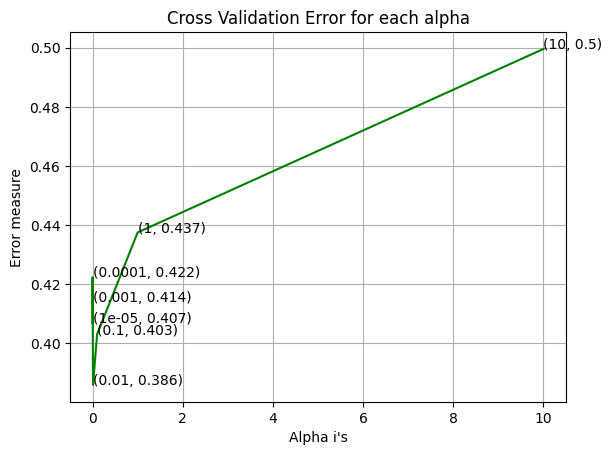

In [17]:
# Define a list of alpha values for the SGD classifier
alpha = [10 ** x for x in range(-5, 2)]

# Initialize an empty list to store the log loss values
log_error_array = []

# Iterate over each alpha value
for i in alpha:
    # Create an SGD classifier with the current alpha value
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)

    # Calibrate the classifier using sigmoid method
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)

    # Predict the probabilities of the classes for the testing data
    predict_y = sig_clf.predict_proba(X_test)

    # Calculate the log loss and append it to the log_error_array
    log_error = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
    log_error_array.append(log_error)

    # Print the log loss for the current alpha value
    print('For values of alpha =', i, "The log loss is:", log_error)

# Plotting the cross-validation error for each alpha value
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='g')

# Annotate the plot with alpha and corresponding log loss values
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


For values of best alpha =  0.01 The train log loss is: 0.3843258293183725
For values of best alpha =  0.01 The test log loss is: 0.3903866097213397
Total number of data points : 30000


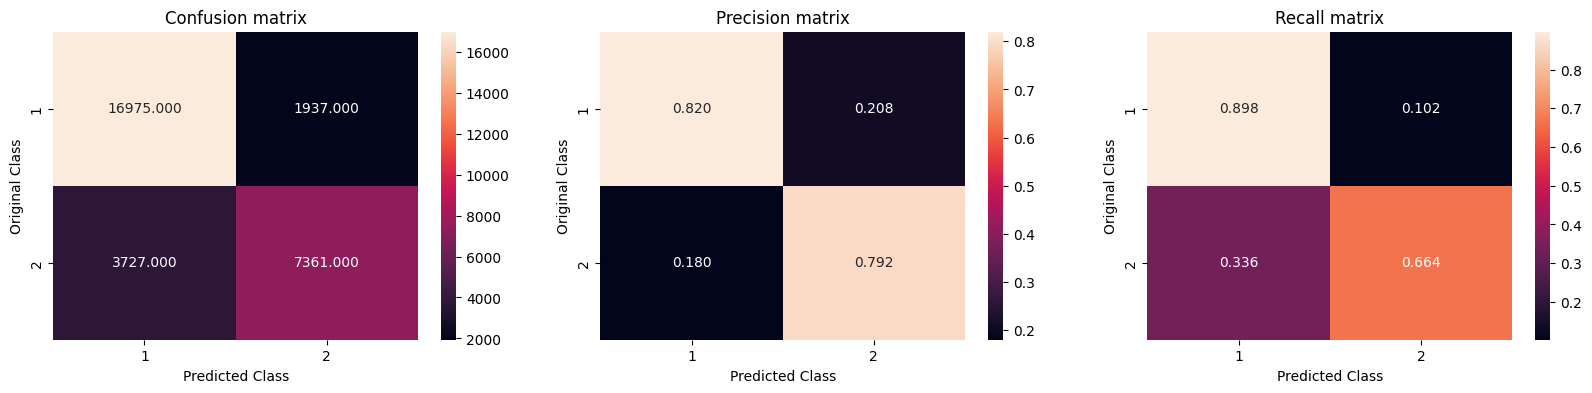

In [ ]:
# Find the index of the best alpha value with minimum log loss
best_alpha = np.argmin(log_error_array)

# Create an SGD classifier with the best alpha value
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)

# Calibrate the classifier using sigmoid method
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

# Predict the probabilities of the classes for the training data
predict_y_train = sig_clf.predict_proba(X_train)
train_log_loss = log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:", train_log_loss)

# Predict the probabilities of the classes for the testing data
predict_y_test = sig_clf.predict_proba(X_test)
test_log_loss = log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:", test_log_loss)

# Predict the labels for the testing data
predicted_y = np.argmax(predict_y_test, axis=1)

# Print the total number of data points
print("Total number of data points:", len(predicted_y))

# Plot the confusion matrix
plot_confusion_matrix(y_test, predicted_y)


Interpretation of precision matrix:

* Of all the points predicted as class1 18% belongs to class 2 and 82% is predicted correct as class1.

* Similarly of all points predicted as class2 79% belongs to class2 and 20% belongs to class1.

Recall matrix:
* Of all actual points belonging to class 1, 89.8% is precied as class 1 and rest 10.2% as class2.
* Similarly, Of all the actual points belonging to class 2, 33% is predicted as class 1 and 66.4% as class2.

## Linear SVM with hinge Loss

For values of alpha =  1e-05 The log loss is: 0.4017455045172091
For values of alpha =  0.0001 The log loss is: 0.4099132256466031
For values of alpha =  0.001 The log loss is: 0.4132846483729001
For values of alpha =  0.01 The log loss is: 0.392458437620356
For values of alpha =  0.1 The log loss is: 0.4146221363836294
For values of alpha =  1 The log loss is: 0.440980076530889
For values of alpha =  10 The log loss is: 0.4951151847450024


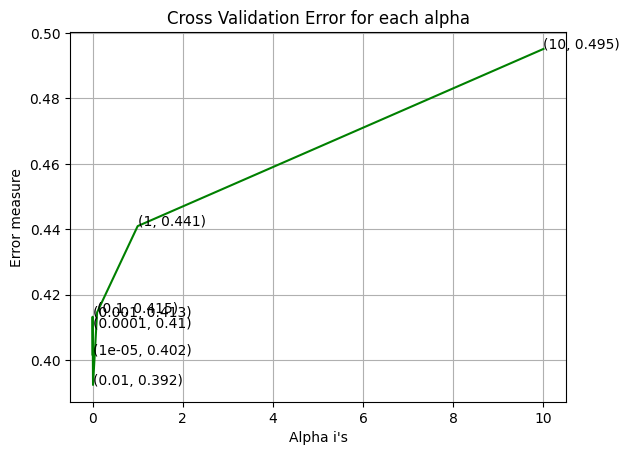

In [ ]:
# Define a list of alpha values for the SGD classifier
alpha = [10 ** x for x in range(-5, 2)]

# Initialize an empty list to store the log loss values
log_error_array = []

# Iterate over each alpha value
for i in alpha:
    # Create an SGD classifier with the current alpha value and 'hinge' loss
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)

    # Calibrate the classifier using sigmoid method
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)

    # Predict the probabilities of the classes for the testing data
    predict_y = sig_clf.predict_proba(X_test)

    # Calculate the log loss and append it to the log_error_array
    log_error = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
    log_error_array.append(log_error)

    # Print the log loss for the current alpha value
    print('For values of alpha =', i, "The log loss is:", log_error)

# Plotting the cross-validation error for each alpha value
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='g')

# Annotate the plot with alpha and corresponding log loss values
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


For values of best alpha =  0.01 The train log loss is: 0.387343333576651
For values of best alpha =  0.01 The test log loss is: 0.392458437620356
Total number of data points : 30000


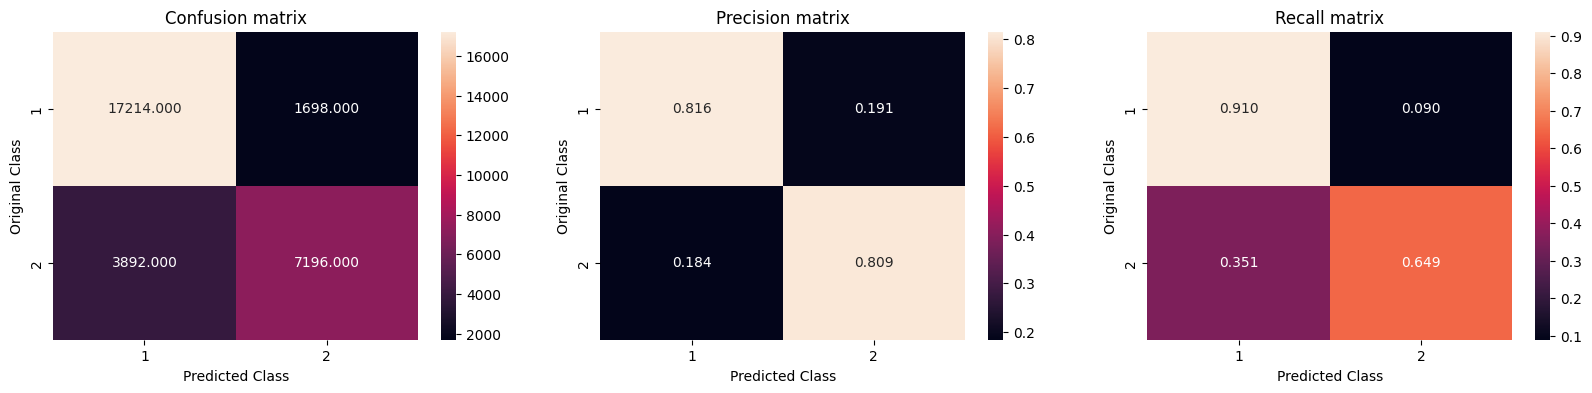

In [ ]:
# Find the index of the best alpha value with minimum log loss
best_alpha = np.argmin(log_error_array)

# Create an SGD classifier with the best alpha value and 'hinge' loss
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)

# Calibrate the classifier using sigmoid method
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

# Predict the probabilities of the classes for the training data
predict_y_train = sig_clf.predict_proba(X_train)
train_log_loss = log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:", train_log_loss)

# Predict the probabilities of the classes for the testing data
predict_y_test = sig_clf.predict_proba(X_test)
test_log_loss = log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:", test_log_loss)

# Predict the labels for the testing data
predicted_y = np.argmax(predict_y_test, axis=1)

# Print the total number of data points
print("Total number of data points:", len(predicted_y))

# Plot the confusion matrix
plot_confusion_matrix(y_test, predicted_y)


## XGBoost Classifier

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for the randomized search
params = {
    'max_depth': [i for i in range(1, 8, 2)],
    'n_estimators': [i * 10 for i in range(1, 10)],
    'gamma': [0, 0.25, 0.5, 1.0],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
}

# Create an XGBoost classifier
xgboost_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_jobs=-1)

# Perform randomized search with cross-validation
xgb_search = RandomizedSearchCV(xgboost_model, param_distributions=params, n_iter=30,
                                scoring='neg_log_loss', n_jobs=-1, cv=3)
xgb_search.fit(X_train, y_train)

# Print the best score and best parameters found by the randomized search
print("Best score:", xgb_search.best_score_)
print("Best parameters:", xgb_search.best_params_)


Best score :  -0.3221554495112588
Best Parameters {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5}


Log loss for tfidf train data :  0.3237436662277681
Log loss for tfidf test data :  0.3297866812062388


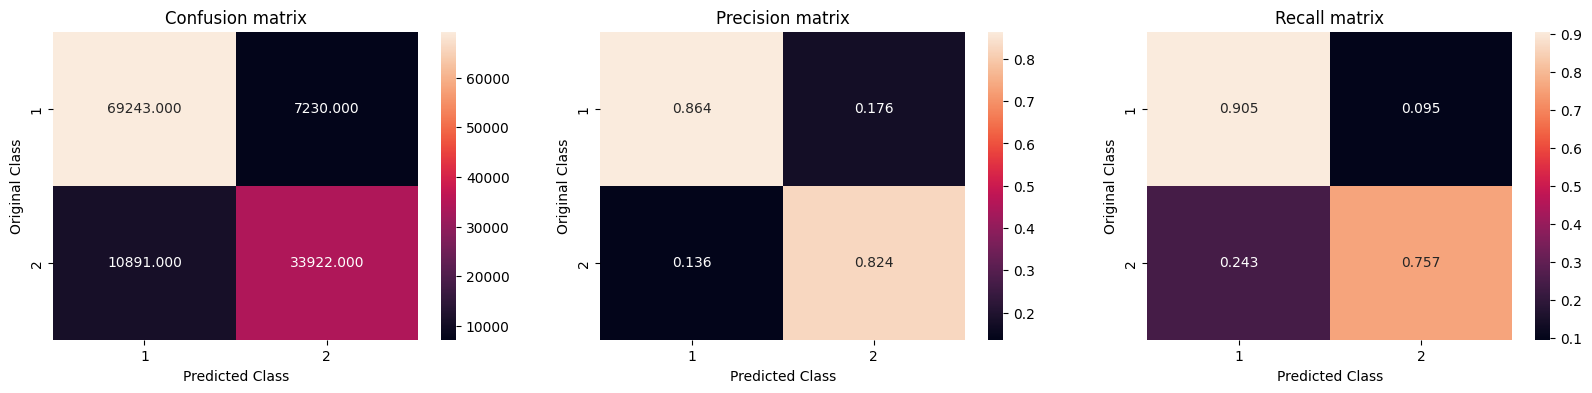

In [ ]:
# Create an XGBoost classifier with the best parameters obtained from the randomized search
clf = xgb.XGBClassifier(**xgb_search.best_params_, objective='binary:logistic', eval_metric='logloss', n_jobs=-1)
clf.fit(X_train, y_train)

# Calibrate the classifier using sigmoid method
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_train, y_train)

# Predict the probabilities of the classes for the training data
predict_y_train = cal_clf.predict_proba(X_train)
train_log_loss = log_loss(y_train, predict_y_train, eps=1e-15)
print("Log loss for tfidf train data:", train_log_loss)

# Predict the probabilities of the classes for the testing data
predict_y_test = cal_clf.predict_proba(X_test)
test_log_loss = log_loss(y_test, predict_y_test, eps=1e-15)
print("Log loss for tfidf test data:", test_log_loss)

# Predict the labels for the testing data
predicted_y = np.argmax(predict_y_test, axis=1)

# Plot the confusion matrix
plot_confusion_matrix(y_test, predicted_y)


# Conclusion

In [18]:
from prettytable import PrettyTable
print("TF-IDF w2v")
x = PrettyTable()
x.field_names = ["ML Model", "Vectorizer", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression",'TF-IDF w2v', 0.3843258293183725, 0.3903866097213397])
x.add_row(["Linear SVM", 'TF-IDF w2v', 0.387343333576651, 0.392458437620356])
x.add_row(["XGBoost", 'TF-IDF w2v', 0.21667200942242115,0.31909646297475824])
print(x)


print("\n TF-IDF vec")
x = PrettyTable()
x.field_names = ["ML Model", "Vectorizer", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression",'TF-IDF ', 0.4362013191694408,0.5394247521413])
x.add_row(["Linear SVM", 'TF-IDF ',0.48846721940918764,0.5444042421387661 ])
x.add_row(["XGBoost", 'TF-IDF ', 0.4560244719803746,0.5163395992548884])
print(x)

TF-IDF w2v
+---------------------+------------+---------------------+---------------------+
|       ML Model      | Vectorizer |    Train log loss   |    Test log loss    |
+---------------------+------------+---------------------+---------------------+
| Logistic Regression | TF-IDF w2v |  0.3843258293183725 |  0.3903866097213397 |
|      Linear SVM     | TF-IDF w2v |  0.387343333576651  |  0.392458437620356  |
|       XGBoost       | TF-IDF w2v | 0.21667200942242115 | 0.31909646297475824 |
+---------------------+------------+---------------------+---------------------+

 TF-IDF vec
+---------------------+------------+---------------------+--------------------+
|       ML Model      | Vectorizer |    Train log loss   |   Test log loss    |
+---------------------+------------+---------------------+--------------------+
| Logistic Regression |  TF-IDF    |  0.4362013191694408 |  0.5394247521413   |
|      Linear SVM     |  TF-IDF    | 0.48846721940918764 | 0.5444042421387661 |
|       X